In [62]:
# imports
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.evaluation.util as util

In [3]:
# define path and file filter
report_log_path = '../logs/class_report'
filter = 'class_report_19epoch.json'

# define metrics to be extracted as list
logs = [['accuracy']
        , ['macro avg', 'precision']
        , ['macro avg', 'recall']
        , ['macro avg', 'f1-score']
        , ['weighted avg', 'precision']
        , ['weighted avg', 'recall']
        , ['weighted avg', 'f1-score']
]

# init dataframe
df_headers = ['run', 'model', 'ratio', 'classes', 'metric', 'value']
df = pd.DataFrame(columns=df_headers)

# iter through logs and get metrics from classification report jsons
counter = 0
for (dirpath, dirnames, filenames) in os.walk(report_log_path):

    if filter in filenames:
        counter += 1

        file_path = dirpath+'/'+filter
        class_report = json.load(open(file_path))

        for log in logs:

            run = dirpath.split('\\', 1)[-1].replace('\\', '_')
            model = re.search('(^[a-z]{5,6})_', run).group(1)
            ratio = float(re.search('(\d{5})r', run).group(1)) / 100
            classes = re.search('(\d{1,2})c', run).group(1)
            
            if len(log) == 1:
                metric = log[0]
                value = class_report[log[0]]
            elif len(log) == 2:
                metric = log[0] + ' ' + log[1]
                value = class_report[log[0]][log[1]]
            
            row = [
                str(run),
                str(model),
                float(ratio),
                str(classes),
                str(metric),
                float(value)
            ]

            df_len = len(df)
            df.loc[df_len] = row

print(f'{counter} classification reports found - df.shape {df.shape}')
df.head()

800 classification reports found - df.shape (5600, 6)


,run,model,ratio,classes,metric,value
0,basic_00000r_14c_20220413-1643,basic,0.0,14,accuracy,0.844503
1,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg precision,0.818496
2,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg recall,0.805868
3,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg f1-score,0.807963
4,basic_00000r_14c_20220413-1643,basic,0.0,14,weighted avg precision,0.853091


In [4]:
df['metric'].unique()

array(['accuracy', 'macro avg precision', 'macro avg recall',
       'macro avg f1-score', 'weighted avg precision',
       'weighted avg recall', 'weighted avg f1-score'], dtype=object)

In [5]:
# check wich training setups have less than 20 runs
df_runs = df.groupby(['model', 'ratio', 'classes', 'metric']).count().reset_index()
df_runs = df_runs.drop('value', axis=1).query('metric == "accuracy"')
df_runs.query('run < 20').sort_values(by=['model', 'ratio', 'classes'], axis=0)

,model,ratio,classes,metric,run


In [45]:
def return_model_name(model:str) -> str:
    return 'bCNN' if model == 'basic' else 'ResNet'

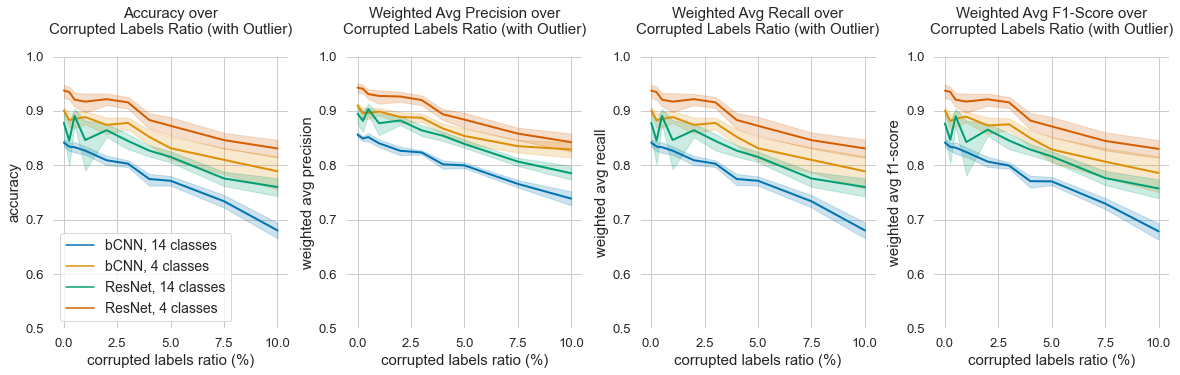

In [74]:
# visualize classification metrics for all four setups >> including outliers <<
font_size = 15

df_temp_main = df.query(f'metric not in ["macro avg f1-score", "macro avg precision", "macro avg recall"]')

df_temp_hue = df_temp_main[['model', 'classes']].apply(
    lambda row: f'{return_model_name(row.model)}, {row.classes} classes', axis=1
)

f, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

for ind, metric in enumerate(df_temp_main['metric'].unique()):

    sns.set_style("whitegrid")
    sns.despine(left=True, bottom=True)
    
    df_temp_vis = df_temp_main.query(f'metric == "{metric}"')
    df_temp_vis = df_temp_vis.rename(columns={'value': metric})
    # df_temp_vis = util.filter_outliers(df_temp_vis, metric, False, 0)

    sns.lineplot(
        data=df_temp_vis,
        x='ratio',
        y=metric,
        hue=df_temp_hue,
        palette='colorblind',
        linewidth=2,
        ax = axes[ind]
    ).set(
        ylim=(0.5,1)
    )
    
    axes[ind].set_xlabel('corrupted labels ratio (%)', size=font_size)
    axes[ind].set_ylabel(metric, size=font_size)
    axes[ind].set_title(f'{metric.title()} over\nCorrupted Labels Ratio (with Outlier)\n', size=font_size)
    
    if ind == 0:
        axes[0].legend(loc='lower left', fontsize=font_size-1)
    else:
        axes[ind].get_legend().remove()

plt.xticks(fontsize=font_size-2)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.draw()
    
f.savefig(f'../assets/classification_metrics_overview_withOutliers.png', dpi=300, facecolor='white', bbox_inches='tight')

	8 outliers filtered
	2 outliers filtered
	8 outliers filtered
	6 outliers filtered


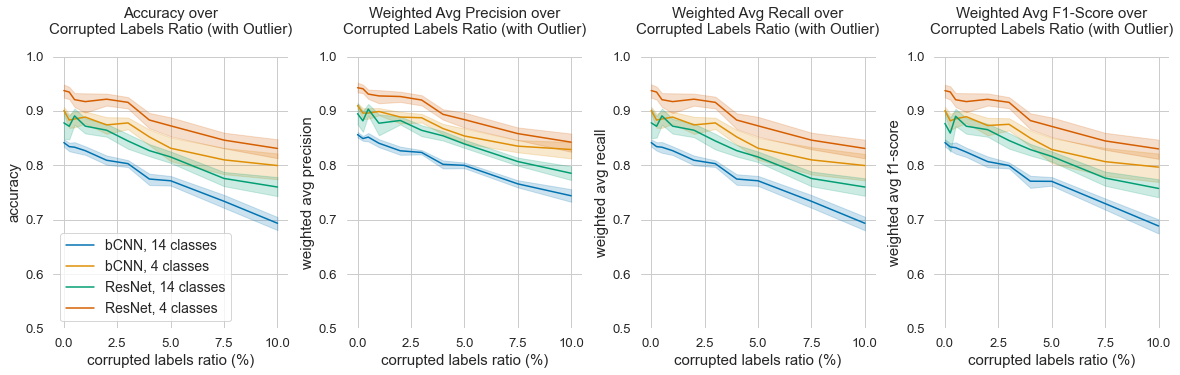

In [75]:
# visualize classification metrics for all four setups >> excluding outliers <<
font_size = 15

df_temp_main = df.query(f'metric not in ["macro avg f1-score", "macro avg precision", "macro avg recall"]')

df_temp_hue = df_temp_main[['model', 'classes']].apply(
    lambda row: f'{return_model_name(row.model)}, {row.classes} classes', axis=1
)

f, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

for ind, metric in enumerate(df_temp_main['metric'].unique()):
    
    sns.set_style("whitegrid")
    sns.despine(left=True, bottom=True)
    
    df_temp_vis = df_temp_main.query(f'metric == "{metric}"')
    df_temp_vis = df_temp_vis.rename(columns={'value': metric})
    df_temp_vis = util.filter_outliers(df_temp_vis, metric, False, 3)

    sns.lineplot(
        data=df_temp_vis,
        x='ratio',
        y=metric,
        hue=df_temp_hue,
        palette='colorblind',
        linewidth=1.5,
        ax = axes[ind]
    ).set(
        ylim=(0.5,1)
    )

    axes[ind].set_xlabel('corrupted labels ratio (%)', size=font_size)
    axes[ind].set_ylabel(metric, size=font_size)
    axes[ind].set_title(f'{metric.title()} over\nCorrupted Labels Ratio (with Outlier)\n', size=font_size)
    
    if ind == 0:
        axes[0].legend(loc='lower left', fontsize=font_size-1)
    else:
        axes[ind].get_legend().remove()

plt.xticks(fontsize=font_size-2)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.draw()

f.savefig(f'../assets/classification_metrics_overview_withoutOutliers.png', dpi=300, facecolor='white', bbox_inches='tight')

In [180]:
# get base stats for classification metrics over average model x classes x ratio setup
group_columns = ['model', 'classes', 'ratio', 'metric']

df_stats = df.query('metric not in \
            ["macro avg f1-score", "macro avg precision", "macro avg recall"]')
df_stats = df_stats.groupby(by=group_columns, as_index=False) \
            .agg({'value':['mean','std']}) \
            .sort_values(group_columns)
            
df_stats_pivot = df_stats.pivot(index=df_stats[['model', 'classes', 'ratio']], columns='metric')['value'].reset_index()
df_stats_pivot.columns = df_stats_pivot.columns.map(' | '.join).str.strip(' | ')

print(df_stats_pivot.shape)
df_stats_pivot.head()

df_stats_pivot.to_excel('../logs/classification_results/classification_metrics_stats_pivot.xlsx', index=False)

(40, 11)


In [193]:
df_stats_pivot.query('ratio == 10')

,model,classes,ratio,mean | accuracy,mean | weighted avg f1-score,mean | weighted avg precision,mean | weighted avg recall,std | accuracy,std | weighted avg f1-score,std | weighted avg precision,std | weighted avg recall
9,basic,14,10.0,0.680102,0.678463,0.738586,0.680102,0.035719,0.034110,0.029199,0.035719
19,basic,4,10.0,0.788874,0.785768,0.828895,0.788874,0.071561,0.075434,0.034534,0.071561
29,resnet,14,10.0,0.759902,0.757283,0.785185,0.759902,0.040120,0.039818,0.030053,0.040120
39,resnet,4,10.0,0.830873,0.830042,0.842399,0.830873,0.039727,0.040315,0.039217,0.039727


--------------

## non-aggregated metric evaluation

--------------

#### accuracy plot per training setup

In [32]:
df_accuracy_setup = df.query("metric == 'accuracy'")
df_accuracy_setup['color'] = df_accuracy_setup['model'] + ' ' + df_accuracy_setup['classes']

C:\Users\daniel.czwalinna\AppData\Local\Temp\ipykernel_1168\4279828007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accuracy_setup['color'] = df_accuracy_setup['model'] + ' ' + df_accuracy_setup['classes']


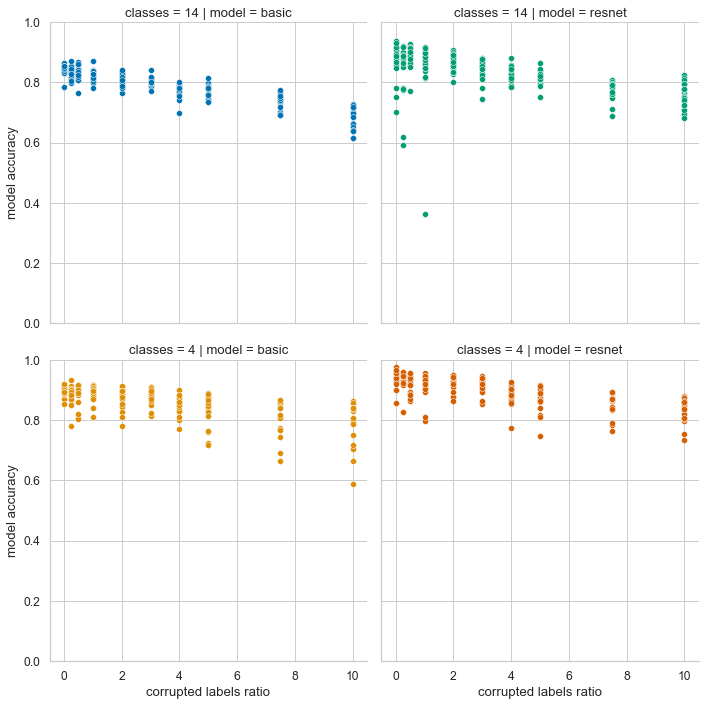

In [33]:

sns.set_style("whitegrid")
g = sns.FacetGrid(
    df_accuracy_setup
    , col='model'
    , row='classes'
    , col_order=['basic', 'resnet']
    , height = 5
    , hue = 'color'
    , palette = 'colorblind'
    , ylim = (0, 1)
    # , xlim = (0,11)
    , sharex = True
    , sharey = True
    , despine = True
)
g.map(sns.scatterplot, 'ratio', 'value')
g.set_axis_labels('corrupted labels ratio', 'model accuracy')

g.savefig('../assets/train_setup_model_accuracy.png', dpi=300, facecolor='white')

--------------

#### accuracy plot

In [7]:
df_accuracy = df.query("metric == 'accuracy'")
print(df_accuracy.shape)
df_accuracy.head()

(800, 6)


,run,model,ratio,classes,metric,value
0,basic_00000r_14c_20220413-1643,basic,0.0,14,accuracy,0.844503
7,basic_00000r_14c_20220413-2345,basic,0.0,14,accuracy,0.844503
14,basic_00000r_14c_20220414-1019,basic,0.0,14,accuracy,0.851280
21,basic_00000r_14c_20220414-1707,basic,0.0,14,accuracy,0.841114
28,basic_00000r_14c_20220415-0056,basic,0.0,14,accuracy,0.847892


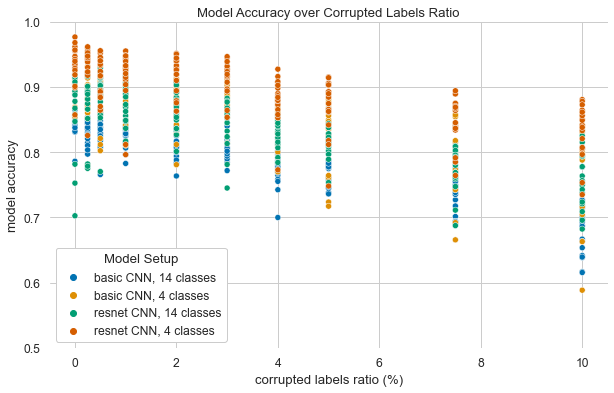

In [9]:
df_hue = df_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_accuracy,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind',
            # s=25,
            # marker='X'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Model Accuracy over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_accuracy.png', dpi=300, facecolor='white')

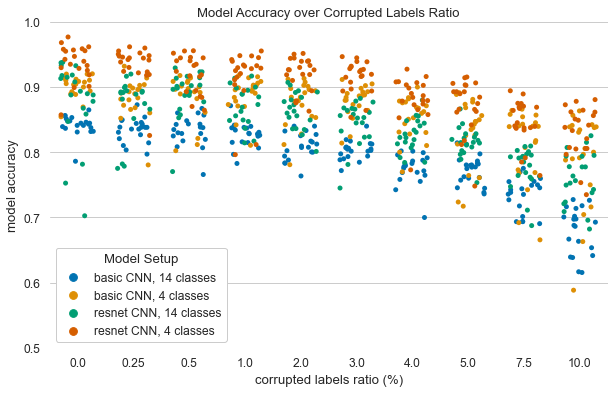

In [10]:
df_hue = df_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.stripplot(
            data=df_accuracy,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind',
            jitter=0.3,
            # s=25,
            # marker='X'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Model Accuracy over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_accuracy_strip.png', dpi=300, facecolor='white')

------------

#### weighted avg precision plot

In [11]:
df_precision_w = df.query("metric == 'weighted avg precision'")
print(df_precision_w.shape)
df_precision_w.head()

(800, 6)


,run,model,ratio,classes,metric,value
4,basic_00000r_14c_20220413-1643,basic,0.0,14,weighted avg precision,0.853091
11,basic_00000r_14c_20220413-2345,basic,0.0,14,weighted avg precision,0.856458
18,basic_00000r_14c_20220414-1019,basic,0.0,14,weighted avg precision,0.871337
25,basic_00000r_14c_20220414-1707,basic,0.0,14,weighted avg precision,0.863243
32,basic_00000r_14c_20220415-0056,basic,0.0,14,weighted avg precision,0.850647


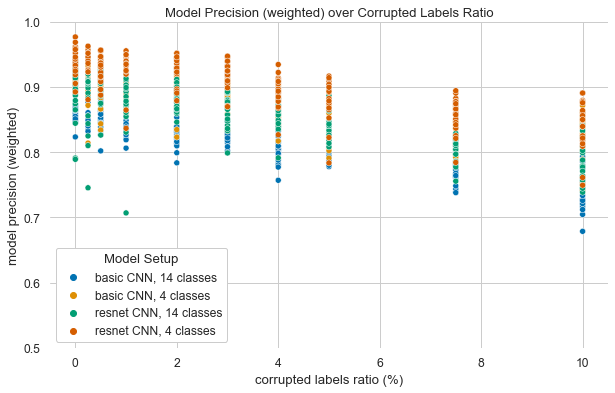

In [12]:
df_hue = df_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_precision_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Model Precision (weighted) over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_precision.png', dpi=300, facecolor='white')

------------

#### weighted avg recall plot

In [13]:
df_recall_w = df.query("metric == 'weighted avg recall'")
print(df_recall_w.shape)
df_recall_w.head()

(800, 6)


,run,model,ratio,classes,metric,value
5,basic_00000r_14c_20220413-1643,basic,0.0,14,weighted avg recall,0.844503
12,basic_00000r_14c_20220413-2345,basic,0.0,14,weighted avg recall,0.844503
19,basic_00000r_14c_20220414-1019,basic,0.0,14,weighted avg recall,0.851280
26,basic_00000r_14c_20220414-1707,basic,0.0,14,weighted avg recall,0.841114
33,basic_00000r_14c_20220415-0056,basic,0.0,14,weighted avg recall,0.847892


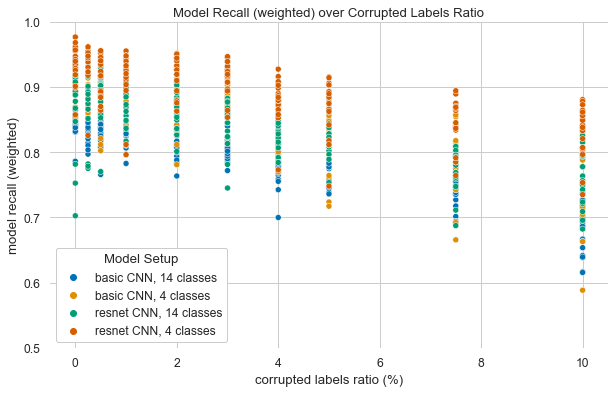

In [14]:
df_hue = df_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_recall_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Model Recall (weighted) over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_recall.png', dpi=300, facecolor='white')

------------

#### weighted avg f1-score plot

In [15]:
df_f1score_w = df.query("metric == 'weighted avg f1-score'")
print(df_f1score_w.shape)
df_f1score_w.head()

(800, 6)


,run,model,ratio,classes,metric,value
6,basic_00000r_14c_20220413-1643,basic,0.0,14,weighted avg f1-score,0.845348
13,basic_00000r_14c_20220413-2345,basic,0.0,14,weighted avg f1-score,0.842549
20,basic_00000r_14c_20220414-1019,basic,0.0,14,weighted avg f1-score,0.854573
27,basic_00000r_14c_20220414-1707,basic,0.0,14,weighted avg f1-score,0.844518
34,basic_00000r_14c_20220415-0056,basic,0.0,14,weighted avg f1-score,0.844609


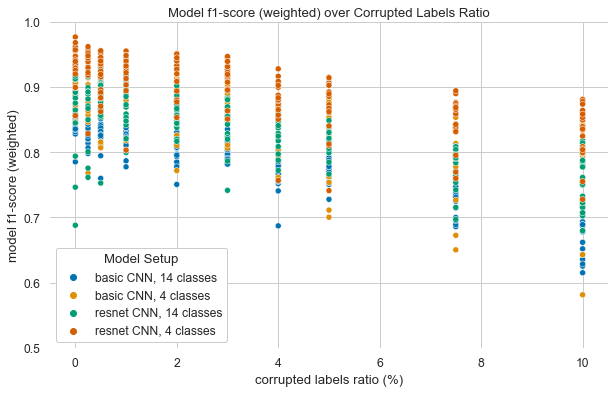

In [16]:
df_hue = df_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_f1score_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Model f1-score (weighted) over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_f1score.png', dpi=300, facecolor='white')

--------------

## aggregated (mean) metric evaluation

In [76]:
df_aggr = df.query('metric==["accuracy", "weighted avg precision", "weighted avg recall", "weighted avg f1-score"]')
df_aggr = df_aggr.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()

df_aggr['delta'] = df_aggr.apply(lambda row:
    row['value'] - df_aggr.query(f'model=="{row.model}" & classes=="{row.classes}" & ratio==0.0 & metric=="{row.metric}"').iloc[0]['value'], axis=1
)

df_aggr

,model,classes,ratio,metric,value,delta
0,basic,14,0.00,accuracy,0.841585,0.000000
1,basic,14,0.00,weighted avg f1-score,0.841569,0.000000
2,basic,14,0.00,weighted avg precision,0.856274,0.000000
3,basic,14,0.00,weighted avg recall,0.841585,0.000000
4,basic,14,0.25,accuracy,0.834243,-0.007342
...,...,...,...,...,...,...
155,resnet,4,7.50,weighted avg recall,0.846141,-0.091152
156,resnet,4,10.00,accuracy,0.830873,-0.106419
157,resnet,4,10.00,weighted avg f1-score,0.830042,-0.107161
158,resnet,4,10.00,weighted avg precision,0.842399,-0.100159


--------------

#### aggr accuracy plot

In [77]:
df_aggr_accuracy = df_aggr.query("metric == 'accuracy'")
print(df_aggr_accuracy.shape)
df_aggr_accuracy.head()

(40, 6)


,model,classes,ratio,metric,value,delta
0,basic,14,0.00,accuracy,0.841585,0.000000
4,basic,14,0.25,accuracy,0.834243,-0.007342
8,basic,14,0.50,accuracy,0.833151,-0.008434
12,basic,14,1.00,accuracy,0.826751,-0.014834
16,basic,14,2.00,accuracy,0.809130,-0.032455


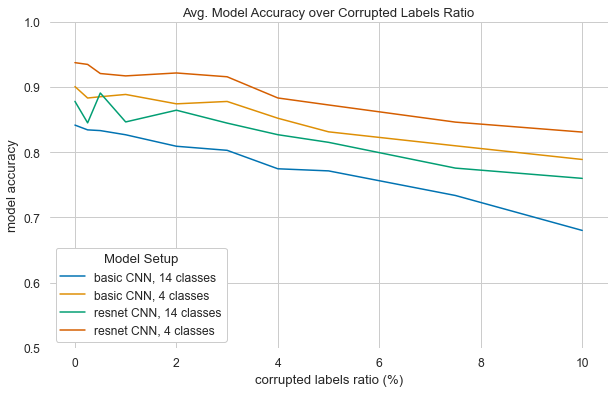

In [78]:
df_hue = df_aggr_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_accuracy,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Avg. Model Accuracy over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_accuracy.png', dpi=300, facecolor='white')

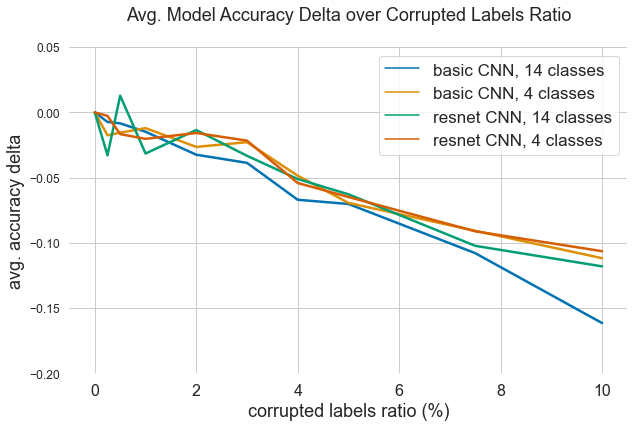

In [100]:
font_size = 18

df_hue = df_aggr_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_accuracy,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind',
            linewidth=2.5
        ).set(
            ylim=(-0.2,0.05),
        )

ax1.set_xlabel('corrupted labels ratio (%)', size=font_size)
ax1.set_ylabel('avg. accuracy delta', size=font_size)
ax1.set_title('Avg. Model Accuracy Delta over Corrupted Labels Ratio\n', size=font_size)
ax1.legend(loc='upper right', fontsize=font_size-1)

plt.xticks(fontsize=font_size-2)

f.savefig('../assets/avg_model_accuracy_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg precision plot

In [21]:
df_aggr_precision_w = df_aggr.query("metric == 'weighted avg precision'")
print(df_aggr_precision_w.shape)
df_aggr_precision_w.head()

(40, 6)


,model,classes,ratio,metric,value,delta
2,basic,14,0.00,weighted avg precision,0.856274,0.000000
6,basic,14,0.25,weighted avg precision,0.849078,-0.007196
10,basic,14,0.50,weighted avg precision,0.851727,-0.004547
14,basic,14,1.00,weighted avg precision,0.840438,-0.015836
18,basic,14,2.00,weighted avg precision,0.826534,-0.029740


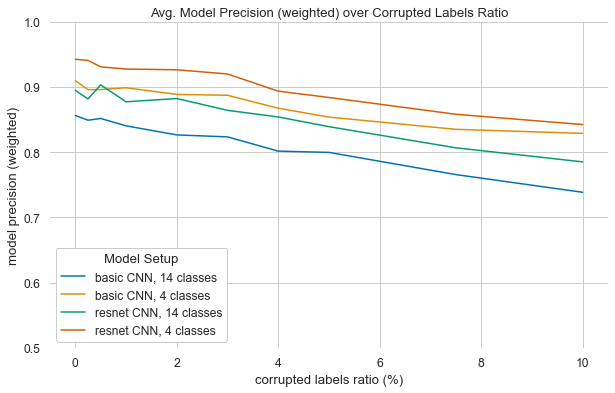

In [22]:
df_hue = df_aggr_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_precision_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Avg. Model Precision (weighted) over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_precision.png', dpi=300, facecolor='white')

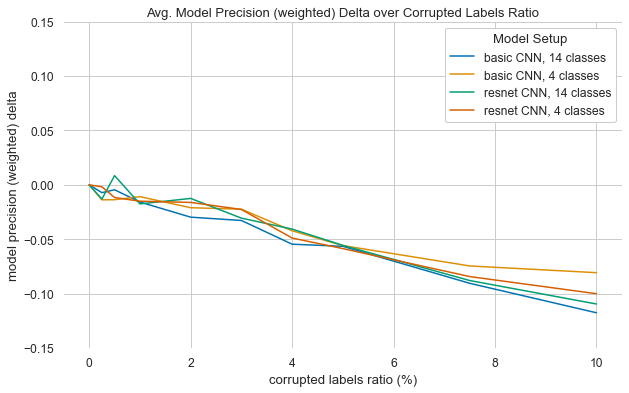

In [23]:
df_hue = df_aggr_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_precision_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model precision (weighted) delta',
            ylim=(-0.15,0.15),
            title='Avg. Model Precision (weighted) Delta over Corrupted Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_precision_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg recall plot

In [24]:
df_aggr_recall_w = df_aggr.query("metric == 'weighted avg recall'")
print(df_aggr_recall_w.shape)
df_aggr_recall_w.head()

(40, 6)


,model,classes,ratio,metric,value,delta
3,basic,14,0.00,weighted avg recall,0.841585,0.000000
7,basic,14,0.25,weighted avg recall,0.834243,-0.007342
11,basic,14,0.50,weighted avg recall,0.833151,-0.008434
15,basic,14,1.00,weighted avg recall,0.826751,-0.014834
19,basic,14,2.00,weighted avg recall,0.809130,-0.032455


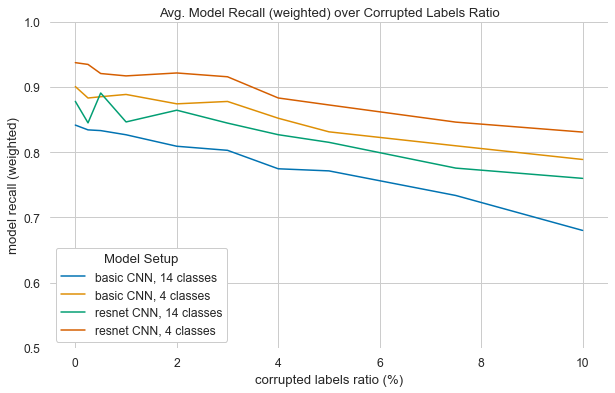

In [25]:
df_hue = df_aggr_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_recall_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Avg. Model Recall (weighted) over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_recall.png', dpi=300, facecolor='white')

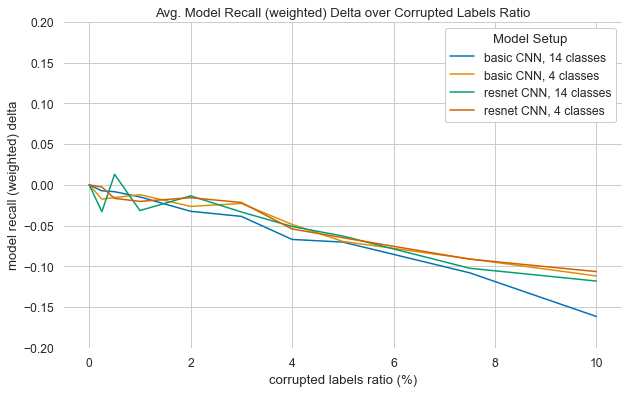

In [26]:
df_hue = df_aggr_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_recall_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model recall (weighted) delta',
            ylim=(-0.2,0.2),
            title='Avg. Model Recall (weighted) Delta over Corrupted Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_recall_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg f1-score plot

In [27]:
df_aggr_f1score_w = df_aggr.query("metric == 'weighted avg f1-score'")
print(df_aggr_f1score_w.shape)
df_aggr_f1score_w.head()

(40, 6)


,model,classes,ratio,metric,value,delta
1,basic,14,0.00,weighted avg f1-score,0.841569,0.000000
5,basic,14,0.25,weighted avg f1-score,0.833636,-0.007933
9,basic,14,0.50,weighted avg f1-score,0.832320,-0.009249
13,basic,14,1.00,weighted avg f1-score,0.824182,-0.017388
17,basic,14,2.00,weighted avg f1-score,0.806645,-0.034924


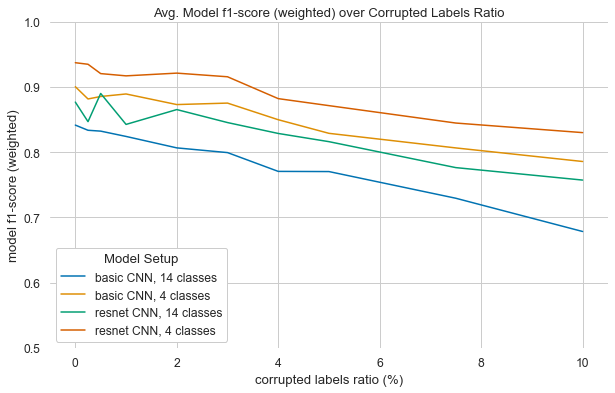

In [28]:
df_hue = df_aggr_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_f1score_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Avg. Model f1-score (weighted) over Corrupted Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_f1score.png', dpi=300, facecolor='white')

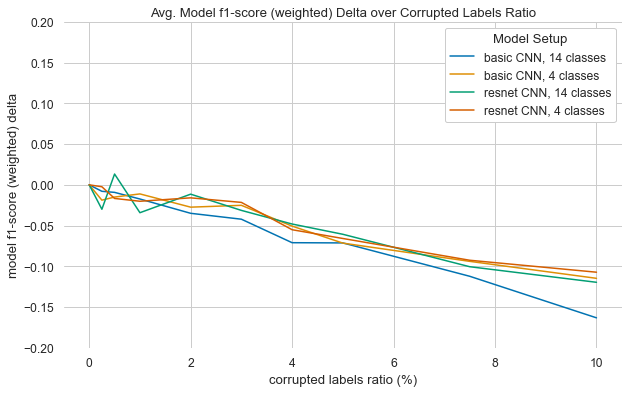

In [29]:
df_hue = df_aggr_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_f1score_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='corrupted labels ratio (%)',
            ylabel='model f1-score (weighted) delta',
            ylim=(-0.2,0.2),
            title='Avg. Model f1-score (weighted) Delta over Corrupted Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_f1score_delta.png', dpi=300, facecolor='white')